<a href="https://colab.research.google.com/github/MScaramuzzi/A1-RNNs-for-Sequence-Labeling/blob/main/Assignment1_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

**Due to**: 11/01/2022 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

**Authors**:

* Sergio Barezzani: sergio.barezzani@studio.unibo.it
* Giuseppe Morgese: giuseppe.morgese2@studio.unibo.it
* Marco Scaramuzzi: marco.scaramuzzi@studio.unibo.it

**Task**: given a corpus of documents, predict the POS tag for each word

**Corpus**: Ignore the numeric value in the third column, use only the words/symbols and its label. The corpus is available at: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

## Primari

3. Evaluation
* History veloce
* Exclude padding from accuracy 
* F1 score confusion matrix

## Secondari
* Better embedding 
* Plot migliori





Importing and installing useful libraries

In [1]:
!pip3 install keras_tuner
!pip install keras-tuner tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 20.9 MB/s 
     |████████████████████████████████| 1.6 MB 62.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 34.1 MB/s 


In [2]:
import urllib.request  #  download files
import tarfile  #  unzip files
import shutil
import os
import urllib.request  #  download files
import zipfile  #  unzip files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
from keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dropout, LSTM, Bidirectional, GRU, Dense, TimeDistributed, Activation,Masking
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,classification_report


#### Ensuring reproducibility

In [3]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
set_reproducibility(42)

## 1. Download the corpora and split it in training and test sets, structuring a dataframe.




**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Splitting**: you can decide to split documents into sentences or not, the choice is yours.


**I/O structure**: The input data will have three dimensions: 1-documents/sentences, 2-token, 3-features; for the output there are 2 possibilities: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes, if you use a single integer that indicates the number of the class it will be 1-documents/sentences, 2-token labels.

#### Dataset downloading

In [5]:
data_folder = os.path.join(os.getcwd(), "Documents")

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path = os.path.join(data_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("Documents")

docs_folder = os.path.join(data_folder, "dependency_treebank")

print("Successful extraction")

Successful download
Successful extraction


Changing the directory the the one of the data 

In [6]:
os.chdir(docs_folder)

In [7]:
# Retrieving file names
data = []

for filename in sorted(os.listdir(docs_folder)):
        data.append(filename)

train_files, val_files, test_files = data[0:100],data[100:150],data[150:200]
file_names = train_files+ val_files+ test_files

In [8]:
def unpack_dataset(files):
    X = []
    y = []
    for file in files:
        with open(file, mode="r", encoding="utf-8") as file_str:
            tokens = []
            tags = []
            for line in file_str.readlines():
                if line.strip() == "": # end of line retrieve 
                            X.append(np.array(tokens))
                            y.append(np.array(tags))
                            tokens = []
                            tags = []
                else:
                    # add token to sentence if the line is not empty 
                    token, tag, _ = line.split("\t")
                    tokens.append(token.lower())
                    tags.append(tag)
            X.append(np.array(tokens))
            y.append(np.array(tags))
    return np.array(X,dtype=object), np.array(y,dtype=object)


In [9]:
X_train_sents, y_train_tags = unpack_dataset(train_files)
X_val_sents, y_val_tags = unpack_dataset(val_files)
X_test_sents, y_test_tags = unpack_dataset(test_files)

### Dataframe creation

In [10]:
# Creating the structure of the dataframe rows
dataframe_rows = {
    'sentences': np.concatenate([X_train_sents, X_val_sents, X_test_sents],axis=0),
    'tags':np.concatenate([y_train_tags, y_val_tags, y_test_tags],axis=0) 
}

In [11]:
df = pd.DataFrame(dataframe_rows)
df.head(10)

,sentences,tags
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
5,"[lorillard, inc., ,, the, unit, of, new, york-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD..."
6,"[although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,..."
7,"[a, lorillard, spokewoman, said, ,, ``, this, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]"
8,"[we, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ..."
9,"[there, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, ., '']"


Dataframe inspection

In [12]:
print(f'Dataset shape: {df.shape} \n')

print(f'Dataset columns: {df.columns.values} \n')

print(f'Dataset Info: \n {df.info} \n')

print('Dataset Head: \n')
print("-"*50)
display(df.head())

Dataset shape: (3914, 2) 

Dataset columns: ['sentences' 'tags'] 

Dataset Info: 
 <bound method DataFrame.info of                                               sentences  \
0     [pierre, vinken, ,, 61, years, old, ,, will, j...   
1     [mr., vinken, is, chairman, of, elsevier, n.v....   
2     [rudolph, agnew, ,, 55, years, old, and, forme...   
3     [a, form, of, asbestos, once, used, to, make, ...   
4     [the, asbestos, fiber, ,, crocidolite, ,, is, ...   
...                                                 ...   
3909  [they, also, said, that, more, than, a, dozen,...   
3910  [sen., kennedy, said, in, a, separate, stateme...   
3911  [trinity, industries, inc., said, it, reached,...   
3912                   [terms, were, n't, disclosed, .]   
3913  [trinity, said, it, plans, to, begin, delivery...   

                                                   tags  
0     [NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...  
1     [NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...  
2 

,sentences,tags
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


### Data exploration
We now wish to understand the structure of the data before encoding it with the GloVe embedding and one-hot encoding the labels. 

We are going to perform some visualization of the distribution of the **tags** in order to make the error analysis, which will be done in the latter part of the notebook, more robust.

In [13]:
# Counting the sentences of each sets
print(f"- Sentences in the train set: {X_train_sents.shape[0]} sentences")
print(f"- Sentences in the validation set: {X_val_sents.shape[0]} sentences")
print(f"- Sentences in the test set: {X_test_sents.shape[0]} sentences")

- Sentences in the train set: 1963 sentences
- Sentences in the validation set: 1299 sentences
- Sentences in the test set: 652 sentences


In [14]:
print(f"Example structure of the arrays: \n {X_train_sents[0:5]} ")

Example structure of the arrays: 
 [array(['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join',
        'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.',
        '29', '.'], dtype='<U12')
 array(['mr.', 'vinken', 'is', 'chairman', 'of', 'elsevier', 'n.v.', ',',
        'the', 'dutch', 'publishing', 'group', '.'], dtype='<U10')
 array(['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former',
        'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',',
        'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this',
        'british', 'industrial', 'conglomerate', '.'], dtype='<U12')
 array(['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make',
        'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high',
        'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group',
        'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', '30',
        'years', 'ago', ',', 'researchers', 'reported', '.'], dtype='<U11')
 ar

The structure is an array (`X_train_sents`) of arrays. The elements of each subarray are the words in each sentence). 

In [15]:
print("Example of a document: ", ' '.join(X_val_sents[13]))
print("Example tags: ", (y_val_tags[13]))

Example of a document:  the potential sales are nearly $ 9.3 million , and house majority whip william gray -lrb- d. , pa . -rrb- began the bidding this year by proposing language that the quota be allocated to english-speaking countries of the caribbean , such as jamaica and barbados .
Example tags:  ['DT' 'JJ' 'NNS' 'VBP' 'RB' '$' 'CD' 'CD' ',' 'CC' 'NNP' 'NNP' 'NNP' 'NNP'
 'NNP' '-LRB-' 'NNP' ',' 'NNP' '.' '-RRB-' 'VBD' 'DT' 'NN' 'DT' 'NN' 'IN'
 'VBG' 'NN' 'IN' 'DT' 'NN' 'VB' 'VBN' 'TO' 'JJ' 'NNS' 'IN' 'DT' 'NNP' ','
 'JJ' 'IN' 'NNP' 'CC' 'NNP' '.']


From the above example we can see that in order to reduce the number of tokens in the OOV dictionaries we have lowercased every word. 

Later we will need to deal with removing ALL the tags that are non explicitly a word (so symbols and punctuation).

In [16]:
all_tags = np.concatenate(np.concatenate([y_train_tags,y_val_tags,y_test_tags])) # flatten tag subarrays
tags, counts = list(np.unique(all_tags, return_counts=True)) # count instances of each tag with return counts
tag_count= dict(zip(tags,counts)) # merge tags and counts in to a dictionary

print("The ten most frequent tags in the whole dataset are: ")
top_ten = dict(sorted(tag_count.items(), key=lambda item: item[1],reverse=True))
print(list(top_ten.items())[0:10])

The ten most frequent tags in the whole dataset are: 
[('NN', 13166), ('IN', 9857), ('NNP', 9410), ('DT', 8165), ('NNS', 6047), ('JJ', 5834), (',', 4886), ('.', 3874), ('CD', 3546), ('VBD', 3043)]


### Understanding content of tag arrays

We need to flatten each arrays with concatenate and then calculate the number of unique tags.

In [17]:
unique_tags_train= np.unique(np.concatenate(y_train_tags))
unique_tags_val = np.unique(np.concatenate(y_val_tags))
unique_tags_test = np.unique(np.concatenate(y_test_tags))

In [18]:
print(f"- Unique tags in train set: {len(unique_tags_train)} tags \n")
print(f"- Unique tags in validation set: {len(unique_tags_val)} tags \n")
print(f"- Unique tags in test set: {len(unique_tags_test)} tags")

- Unique tags in train set: 45 tags 

- Unique tags in validation set: 44 tags 

- Unique tags in test set: 40 tags


In [19]:
print("- Tags that are present in the train set and are not present in the validation set:",list(set(unique_tags_train).difference(set(unique_tags_val))))
print()
print("- Tags that are present in the train set and are not present in the test set:",list(set(unique_tags_train).difference(set(unique_tags_test))))
print()
print("- Tags that are present in the validation set and are not present in the test set:",list(set(unique_tags_val).difference(set(unique_tags_test))))

- Tags that are present in the train set and are not present in the validation set: ['SYM']

- Tags that are present in the train set and are not present in the test set: ['SYM', 'FW', 'UH', 'LS', '#']

- Tags that are present in the validation set and are not present in the test set: ['LS', '#', 'FW', 'UH']


### Getting max sentence length

We need to retrieve the maximum sentence lenght in order to perform the correct encoding of the data with the necessary padding. 

Each sentence has different lenght therefore we need to encode each sentence with the maximum size possible.

In [20]:
print(f"Max sentence length is: {df.sentences.str.len().max()}")

Max sentence length is: 249


In [21]:
max_size = 250

### Retrieving punctuation indices 

This will be useful later for error analysis

In [22]:
sort_tags = np.array(sorted(unique_tags_train))

In [23]:
sort_tags = np.append(sort_tags,'UNK')

In [24]:
print(sort_tags)

['#' '$' "''" ',' '-LRB-' '-RRB-' '.' ':' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN'
 'JJ' 'JJR' 'JJS' 'LS' 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP'
 'PRP$' 'RB' 'RBR' 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP'
 'VBZ' 'WDT' 'WP' 'WP$' 'WRB' '``' 'UNK']


UNK is last for generalization purposes of the encoding approach.

We need to the remove the indices associated with the following symbols:

* Punctuation:
  - -LRB- &rarr; "Left Round Bracket" &rarr; "({"
  - -RRB- &rarr; "Right Round Bracket" &rarr; "){"
  - # 
  - $
  - ' ' 
  - , 
  - . 
  - : 


* Symbols:

  - LS &rarr; List item marker
  - SYM &rarr; Symbol
  - ``

In [25]:
indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] # symbols and punctuation
print("Displaying the tags to remove and their associated index: \n")
print(dict(zip(sort_tags[indices],indices)))

Displaying the tags to remove and their associated index: 

{'#': 0, '$': 1, "''": 2, ',': 3, '-LRB-': 4, '-RRB-': 5, '.': 6, ':': 7, 'LS': 17, 'SYM': 31, '``': 44}


## Encoding the dataset


Generating embedding dictionary for GloVe 

In [26]:
# Download the GloVe embeddings
!gdown https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the GloVe embeddings file
!unzip -q -o glove.6B.zip -d embeddings

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /content/Documents/dependency_treebank/glove.6B.zip
100% 862M/862M [02:39<00:00, 5.42MB/s]


We choose an embedding dimension of size 100d in order to have a good tradeoff between performance and time spent training.

It is also possible to experiment with other sizes such as 50,200 or 300. Through experimenting we have found that 100 is enough for our purposes.

In [27]:
""" 
Retrieving GloVe embedding from file and then generating a dictionary
where each vord is a key and the value is the embedding vector. 
"""
V1 = {}
with open(docs_folder+"/embeddings/glove.6B.100d.txt", 'r') as f:
    for i,line in enumerate(f):
        values = line.split()
        word = values[0]
        # if word = regex numbers then get embedding for first number
        vector = np.asarray(values[1:], "float32")
        V1[word] = vector

### OOV handling

The OOV words will be assigned a random embedding sampled from uniform distribution, in the range `[-0.5,+0.5]` in order to match it with the numerical range of GloVe embeddings. It is also possible to experiment with other types of embedding for OOV.

In [28]:
embedding_dim = 100 # chosen as compromise between time spent training and performance

In [29]:
def generate_oov(emb_dictionary, tokens,embedding_dim):
    """
    Checks wheter a token is not present in the vocabulary containing the embeddings,
    if it is not present, then insert it in the dictionary of the OOV words with a random value
    sampled from an uniform distribution in the correct range (the one of glove embeddings).
    """
    oov_dict = {} # create oov dict
    for token in tokens: 
        if token not in emb_dictionary:
            oov_dict[token]= np.random.uniform(-0.5, 0.5, size=embedding_dim)
    return oov_dict

In [30]:
# Flatten the arrays of each data split to get all the tokens 
train_toks = np.concatenate(np.concatenate([X_train_sents]))
val_toks = np.concatenate(np.concatenate([X_val_sents]))
test_toks = np.concatenate(np.concatenate([X_test_sents]))

In [31]:
# From the above flattened arrays retrieve the unique tags 
unique_train_toks = np.unique(train_toks)
unique_val_toks = np.unique(val_toks)
unique_test_toks = np.unique(test_toks)


We now need to encode the features and the labels in numeric format in order to be able to process it with a neural network. 

* The features (*X_train_sents* and all others features arrays) will be encoded through a GloVe embedding if they are in the dictionary. If they are OOV they will be encoded with a random value sampled from an uniform distribution.
    * the *X_train_sents* array has a structure of being an array of arrays with only one dimension. We wish to encode this in a 3D format with the following shape:

    ```
    (number_of_sentences,max_sentence_lenght,embedding_dimension)
    ```

AGGIUNGI SPIEGAZIONE CO-OCCURRENCE MATRIX

Defining a function for padding the y_tags later

In [32]:
def pad(array, target_shape):
    return np.pad(
        array,
        [(0, target_shape[i] - array.shape[i]) for i in range(len(array.shape))],
        "constant",
    )

In [33]:
# encode each word of a sentence in a numpy array
def encode_sentence(sentence,vocabulary):
    return np.array([vocabulary[word] for word in sentence])

In [34]:
# use the above defined function to encode each word in a sentence and then appending it to an array 
# then this array is constructed with the right shape defined above.
def encode_features(array,vocabulary):
  result = []
  for sentence in array:
    pad_size = (max_size-len(sentence), embedding_dim)
    encoded = encode_sentence(sentence,vocabulary) 
    result.append(
              np.row_stack((encoded, np.zeros(pad_size)))
            )
  return np.array(result)

1. Starting vocabulary *V1* (in this assignment, GloVe vocabulary)
2. Compute embeddings for terms out of vocabulary *OOV1* of the training split
3. Add embeddings to the vocabulary, so to obtain vocabulary *V2* which is the concatenation of *V1* and *OOV1*
4. Compute embeddings for terms  of the validation split *OOV2*
5. Add embeddings to the vocabulary, so to obtain vocabulary *V3* = *V2* + *OOV2*
6. Compute embeddings for terms  of the test split *OOV3*
7. Add embeddings to the vocabulary, so to obtain vocabulary *V4* = *V3* + *OOV3*

In [35]:
print("- Generating the OOV for train set... \n")
OOV1 = generate_oov(V1,unique_train_toks,embedding_dim)


print("- Merging initial vocabulary and OOV1... ")
V2 = {**V1,**OOV1} # using dictionary synthax to merge dictionaries
X_train= encode_features(X_train_sents,V2)
print(f"\n- Shape of the training set: {X_train.shape} \n")

print("- Generating the OOV for validation set... \n")
OOV2 = generate_oov(V2,unique_val_toks,embedding_dim)

print("- Merging V2 and OOV2: ")
V3 = {**V2,**OOV2}
X_val= encode_features(X_val_sents,V3)
print(f"\n- Shape of the validation set: {X_val.shape} \n")

print("- Generating the OOV for test set... \n")
OOV3 = generate_oov(V3,unique_test_toks,embedding_dim)

print("- Merging V4 and OOV4... ")
V4 = {**V3,**OOV3}
X_test= encode_features(X_test_sents,V4)
print(f"\n- Shape of the test set: {X_test.shape} \n")

- Generating the OOV for train set... 

- Merging initial vocabulary and OOV1... 

- Shape of the training set: (1963, 250, 100) 

- Generating the OOV for validation set... 

- Merging V2 and OOV2: 

- Shape of the validation set: (1299, 250, 100) 

- Generating the OOV for test set... 

- Merging V4 and OOV4... 

- Shape of the test set: (652, 250, 100) 



Retrieve the OOV sets and then use a set data structure for storing it.

In [36]:
train_oov_terms = set(OOV1.keys())
val_oov_terms = set(OOV2.keys())
test_oov_terms = set(OOV3.keys())

Get the OOV terms unique for the val set and the test set.

In [37]:
specific_val_oov_terms = val_oov_terms - train_oov_terms
specific_test_oov_terms = test_oov_terms - train_oov_terms - val_oov_terms

In [38]:
print(
    f"Total training OOV terms: {len(train_oov_terms)} ({round(len(train_oov_terms) / len(unique_train_toks), 2)}%)"
)

print(
    f"Total validation OOV terms: {len(specific_val_oov_terms)} ({round(len(specific_val_oov_terms) / len(unique_val_toks), 2)}%)"
)
print(
    f"Total testing OOV terms: {len(specific_test_oov_terms)} ({round(len(specific_test_oov_terms) / len(unique_test_toks), 2)}%)"
)


Total training OOV terms: 359 (0.05%)
Total validation OOV terms: 189 (0.03%)
Total testing OOV terms: 128 (0.04%)


Now that we have all the ingredients to build the embedding matrix , we provide a method that builds the matrix given the GloVe model and a defined vocabulary of wrods, that explicits a one-to-one mapping between each word and a number. We have decided to assign a uniformly generated random vector for OOV terms since they are a little percentage with respect to all the terms present in the dataset

The percentage of OOV for each data split is negligible, let's inspect content of OOV arrays.

In [39]:
print("- Train set OOV words:",list(OOV1.keys()))
print()
print("- Validation set OOV words:",list(OOV2.keys()))
print()
print("- Test set OOV words:",list(OOV3.keys()))

- Train set OOV words: ['-lcb-', '-lrb-', '-rcb-', '-rrb-', '1.457', '1.5755', '1.8415', '100,980', '11,762', '12,252', '127.03', '13,056', '14,821', '142.85', '143.08', '143.80', '143.93', '16,072', '16.125', '18,444', '1\\/10th', '1\\/2', '1\\/4', '2,303,328', '230-215', '234.4', '236.74', '236.79', '2645.90', '271,124', '278.7', '3,288,453', '3.253', '30,841', '3057', '352.7', '361,376', '37-a-share', '374.19', '374.20', '38.375', '382-37', '3\\/4', '4,393,237', '4.898', '415.6', '415.8', '436.01', '446.62', '449.04', '456.64', '497.34', '5.276', '500,004', '520-lawyer', '5\\/8', '62%-owned', '62.625', '69-point', '70-a-share', '705.6', '737.5', '7\\/8', '82,389', '8300s', '84-month', '9,118', '90-cent-an-hour', '95,142', 'abortion-related', 'ac-130u', 'achievement-test', 'akerfeldt', 'alurralde', 'amphobiles', 'anti-abortionists', 'anti-china', 'anti-takeover', 'antitrust-law', 'ariail', 'aslacton', 'asset-sale', 'autions', 'auto-safety', 'automotive-lighting', 'automotive-parts', 

We can see that most of the OOV words are numbers and composite words. Also there is a POS wrongly represented in the sentence ( the wort 'lrb' is present in the GloVe embedding instead '-lcb-' is not). 

We will not pre-process these OOV words  given that they are very infrequent.

###  One Hot Encoding of POS Tags


The task to the performed by the model is a multi-class classification therefore the labels are not encoded assigning integer values to each different class, but rather by one hot encoding.

In [40]:
from sklearn.preprocessing import OneHotEncoder

* The labels (*y_train_tags* and all others labels arrays) will be one hot encoded and will need to have the following shape:

    ```
    (number_of_sentences,max_sentence_lenght,number_of_tags )
    ```

In [41]:
ohe = OneHotEncoder(sparse=False) # Get one hot encoding for POS tags in the training dataset
ohe.fit(sort_tags.reshape(-1,1))

OneHotEncoder(sparse=False)

In [42]:
max_tags = len(sort_tags) 

In [43]:
"""
This function 
array: Input array should be the an array 
which contains the tags of each sentence that will be one hot encoded

max_size is the max sentence lenght: 250
max_tags is the maximum number of tags: 46
"""

def ohe_convert_shape(array):
    result = []
    for i,tags in enumerate(array):
        encoded = ohe.transform(tags.reshape(-1,1))
        padding = (max_size,max_tags)
        result.append(pad(encoded,padding))
    return np.array(result)

In [44]:
y_train = ohe_convert_shape(y_train_tags)
y_val = ohe_convert_shape(y_val_tags)
y_test = ohe_convert_shape(y_test_tags)

Displaying the OneHotEncoded arrays

In [52]:
print(X_train_sents[0])
print()
print(y_train_tags[0])
print("\nDisplaying One Hot Encoding of the first words in the first sentence of the train set:\n")

print(f"\nEncoding of first tag: {y_train_tags[0][0]}")
print(y_train[0][0])
print()
print(f"Encoding of second tag: {y_train_tags[0][1]}")
print(y_train[0][1])
print()
print(f"Encoding of the third tag: {y_train_tags[0][2]}")
print(y_train[0][2])


['pierre' 'vinken' ',' '61' 'years' 'old' ',' 'will' 'join' 'the' 'board'
 'as' 'a' 'nonexecutive' 'director' 'nov.' '29' '.']

['NNP' 'NNP' ',' 'CD' 'NNS' 'JJ' ',' 'MD' 'VB' 'DT' 'NN' 'IN' 'DT' 'JJ'
 'NN' 'NNP' 'CD' '.']

Displaying One Hot Encoding of the first words in the first sentence of the train set:


Encoding of first tag: NNP
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Encoding of second tag: NNP
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Encoding of the third tag: ,
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The first two tags have the same one hot encoding given that they are NNP. The third tag is a comma and it is represented with a different encoding.

In [53]:
print(f"- Shape of the train set: {y_train.shape}")
print()
print(f"- Shape of the validation set: {y_val.shape}")
print()
print(f"- Shape of the test set: {y_test.shape}")

- Shape of the train set: (1963, 250, 46)

- Shape of the validation set: (1299, 250, 46)

- Shape of the test set: (652, 250, 46)


# 3. Modeling




### Architectures used:
#### Baseline model
* Bidirectional LSMT + Dense layer 

#### Variations
* Bidirectional GRU + Dense layer
* Two Bidirectional LSMT + Dense layer
* Bidirectional LSMT + Two Dense layer

In [54]:
n_classes = y_train.shape[2] # 46

In [56]:
tfa_f1 = tfa.metrics.F1Score(
    num_classes= n_classes,
    name = 'f1_score',
    )

indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] 

def f1_with_tfa(y_true, y_pred):
    """
    Computes the F1 score using TensorFlow.
    The punctuation is ignored.
    """
    y_true = tf.reshape(y_true, (-1, n_classes))


    punctuation = tf.gather(y_true, indices, axis=-1)

    y_mask = tf.cast(tf.logical_not(tf.reduce_any( \
                    tf.cast(punctuation, tf.bool), axis=-1)), tf.float32)
    
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    
    tfa_f1.update_state(y_true, y_pred, sample_weight=y_mask)
    
    result = tfa_f1.result()
    
    K.batch_set_value([(v, np.zeros(v.shape.as_list())) for v in tfa_f1.variables])
    return K.sum(result)/(n_classes-len(indices))


## Baseline model

### Model 1: BILST with a Dense layer

Below we define the model architecture with some hyperparameter specified. The Masking layers is useful for ignoring the padding of the X array.

In [57]:
  # Define the model architecture
def BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding_x', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

## Other models

### Model 2: GRU

In [58]:
# Create BiGRU and Dense layer
def BiGRU(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(GRU(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="gru_1")))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))   
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

### Model 3: Two BILSTM

In [59]:
# Create model with two BiLSTM layers and Dense layer
def two_BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_2")))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))   
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

### Model 4: BILSTM + Dense Layer

In [60]:
# Create model with one BiLSTM layers and two Dense layers
def bilstm_two_dense(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))      
    model.add(TimeDistributed(Dense(units=hp.Int('units2', min_value=64, max_value=256, step=64),activation="relu",name="dense_1")))
    model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))   
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_2")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

## 3.2 Hyperparameter tuning

### Model 1: BILST with a Dense layer 

In [61]:
# Hyperparameter optimization using random search
tuner_bilstm = RandomSearch(BiLSTM, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=4,seed=42, overwrite=True)
tuner_bilstm.search(X_train,y_train, epochs=10, validation_data=(X_val, y_val))

best_hps_bilstm = tuner_bilstm.get_best_hyperparameters()[0]

print(f"Hyper parameter tuning completed.\n" 
      f"=====================================\n"
      f"The optimal rate for the Dropout layer is {best_hps_bilstm.get('dropout')}.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")

Trial 4 Complete [00h 00m 53s]
val_f1_with_tfa: 0.12459729611873627

Best val_f1_with_tfa So Far: 0.4421629011631012
Total elapsed time: 00h 02m 28s
Hyper parameter tuning completed.
The optimal rate for the Dropout layer is 0.0.
The optimal number of units in the LSTM layer is 192.
The optimal learning rate for the optimizer is 0.001.


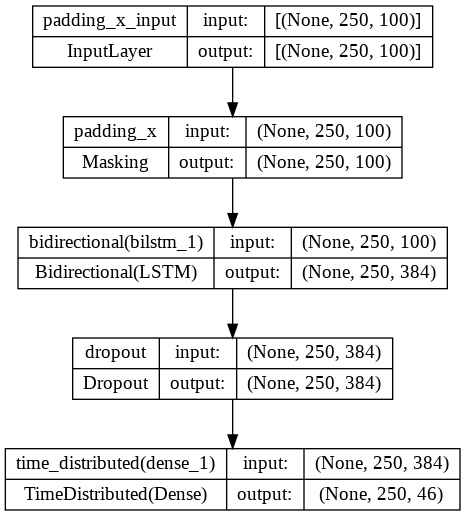

In [62]:
from keras.utils.vis_utils import plot_model
plot_model(tuner_bilstm.get_best_models()[0], show_shapes=True, show_layer_names=True)

### Model 2: Bidirectional GRU + Dense layer 

In [63]:
# Hyperparameter optimization using random search
tuner_bigru = RandomSearch(BiGRU, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=3, overwrite=True,seed=42)
tuner_bigru.search(X_train,y_train, epochs=10, validation_data=(X_val, y_val))

best_hps_bigru = tuner_bigru.get_best_hyperparameters()[0]

print(f"Hyper parameter tuning completed.\n" 
      f"=====================================\n" 
      f"The optimal rate for the Dropout layer is {best_hps_bigru.get('dropout')}.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bigru.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bigru.get('learning_rate')}.")

Trial 3 Complete [00h 00m 30s]
val_f1_with_tfa: 0.11457956582307816

Best val_f1_with_tfa So Far: 0.4702557921409607
Total elapsed time: 00h 01m 53s
Hyper parameter tuning completed.
The optimal rate for the Dropout layer is 0.0.
The optimal number of units in the LSTM layer is 192.
The optimal learning rate for the optimizer is 0.001.


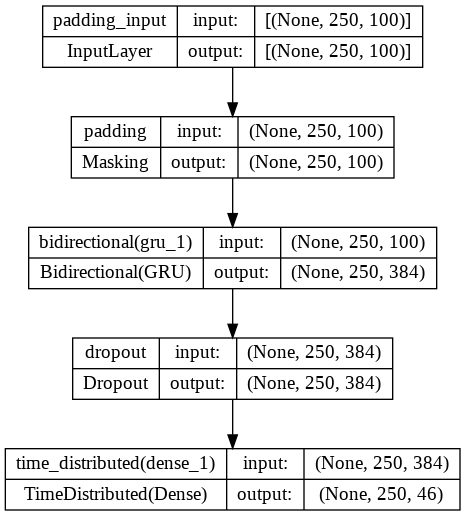

In [64]:
plot_model(tuner_bigru.get_best_models()[0], show_shapes=True, show_layer_names=True)

### Model 3:  Two Bidirectional LSMT + Dense layer 

In [65]:
# Hyperparameter optimization using random search
tuner_two_bilstm = RandomSearch(two_BiLSTM, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=4, overwrite=True)
tuner_two_bilstm.search(X_train,y_train, epochs=15, validation_data=(X_val, y_val))

best_hps_two_bilstm = tuner_two_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_two_bilstm.get('units')}.\n" 
        f"The optimal rate for the Dropout layer is {best_hps_two_bilstm.get('dropout')}.\n" 

      f"The optimal number of units in the second LSTM layer is {best_hps_two_bilstm.get('units2')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 4 Complete [00h 01m 02s]
val_f1_with_tfa: 0.021917643025517464

Best val_f1_with_tfa So Far: 0.3000120520591736
Total elapsed time: 00h 05m 24s
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 128.
The optimal rate for the Dropout layer is 0.30000000000000004.
The optimal number of units in the second LSTM layer is 192.
The optimal learning rate for the optimizer is 0.001.


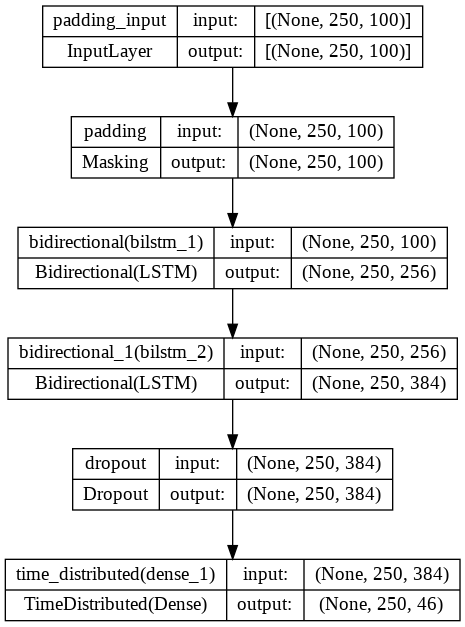

In [66]:
plot_model(tuner_two_bilstm.get_best_models()[0], show_shapes=True, show_layer_names=True)

### Model 4: Bidirectional LSMT + two Dense layer 

In [67]:
# Hyperparameter optimization using random search
tuner_bilstm_two_dense = RandomSearch(bilstm_two_dense, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=3,seed=42, overwrite=True)
tuner_bilstm_two_dense.search(X_train,y_train, epochs=10, validation_data=(X_val, y_val))

best_hps_bilstm_two_dense = tuner_bilstm_two_dense.get_best_hyperparameters()[0]

print(f"\n Hyperparameter tuning done.\n" 
              f"The optimal rate for the first Dropout layer is {best_hps_bilstm_two_dense.get('dropout_1')}.\n" 
        f"The optimal rate for the secibd Dropout layer is {best_hps_bilstm_two_dense.get('dropout_2')}.\n" 

      f"The optimal number of units in the LSTM layer is {best_hps_bilstm_two_dense.get('units')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_bilstm_two_dense.get('units2')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm_two_dense.get('learning_rate')}.")

Trial 3 Complete [00h 00m 32s]
val_f1_with_tfa: 0.2328069508075714

Best val_f1_with_tfa So Far: 0.5809867978096008
Total elapsed time: 00h 01m 31s

 Hyperparameter tuning done.
The optimal rate for the first Dropout layer is 0.0.
The optimal rate for the secibd Dropout layer is 0.1.
The optimal number of units in the LSTM layer is 192.
The optimal number of units in the second LSTM layer is 128.
The optimal learning rate for the optimizer is 0.01.


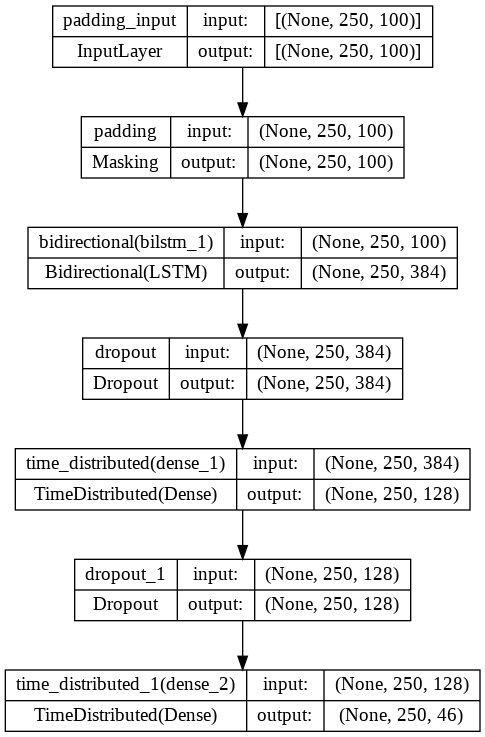

In [68]:
plot_model(tuner_bilstm_two_dense.get_best_models()[0], show_shapes=True, show_layer_names=True)

##  3.3 Model training

### Model 1: Bidirectional LSMT + Dense layer 


Using accuracy for early stopping because it is not really possibile to gauge F1-score  on  mini-batches.

In [69]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode="max", restore_best_weights=True)]

In [70]:
# Train the best model for 10 epochs
best_bilstm = tuner_bilstm.hypermodel.build(best_hps_bilstm)
best_bilstm.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_bilstm.save('models/bilstm.h5')

Epoch 1/100
31/31 [==============================] - 11s 128ms/step - loss: 2.3990 - categorical_accuracy: 0.1813 - f1_with_tfa: 0.0232 - val_loss: 1.2496 - val_categorical_accuracy: 0.2061 - val_f1_with_tfa: 0.0288
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 0.7765 - categorical_accuracy: 0.2727 - f1_with_tfa: 0.0451 - val_loss: 0.4476 - val_categorical_accuracy: 0.3561 - val_f1_with_tfa: 0.0733
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 0.3284 - categorical_accuracy: 0.4158 - f1_with_tfa: 0.0898 - val_loss: 0.2493 - val_categorical_accuracy: 0.4650 - val_f1_with_tfa: 0.1213
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 0.2179 - categorical_accuracy: 0.5087 - f1_with_tfa: 0.1538 - val_loss: 0.1996 - val_categorical_accuracy: 0.5191 - val_f1_with_tfa: 0.1665
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 0.1864 - categorical_accuracy: 0.5662 - f1_with_tfa: 0.1946 - val_lo

### Model 2: Bidirectional GRU + Dense layer 



In [71]:
# Train the best model for 10 epochs
best_bigru = tuner_bigru.hypermodel.build(best_hps_bigru)
best_bigru.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_bigru.save('models/bigru.h5')

Epoch 1/100
31/31 [==============================] - 11s 123ms/step - loss: 2.4300 - categorical_accuracy: 0.2377 - f1_with_tfa: 0.0392 - val_loss: 1.3659 - val_categorical_accuracy: 0.3370 - val_f1_with_tfa: 0.0587
Epoch 2/100
31/31 [==============================] - 1s 32ms/step - loss: 0.8699 - categorical_accuracy: 0.4426 - f1_with_tfa: 0.0927 - val_loss: 0.5025 - val_categorical_accuracy: 0.5088 - val_f1_with_tfa: 0.1544
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 0.3508 - categorical_accuracy: 0.5517 - f1_with_tfa: 0.1845 - val_loss: 0.2474 - val_categorical_accuracy: 0.5771 - val_f1_with_tfa: 0.2060
Epoch 4/100
31/31 [==============================] - 1s 32ms/step - loss: 0.2041 - categorical_accuracy: 0.6271 - f1_with_tfa: 0.2696 - val_loss: 0.1793 - val_categorical_accuracy: 0.6282 - val_f1_with_tfa: 0.2722
Epoch 5/100
31/31 [==============================] - 1s 32ms/step - loss: 0.1637 - categorical_accuracy: 0.6686 - f1_with_tfa: 0.3163 - val_lo

### Model 3:  Two Bidirectional LSMT + Dense layer 

In [72]:
# Train the best model for 10 epochs
best_two_bilstm= tuner_two_bilstm.hypermodel.build(best_hps_two_bilstm)
best_two_bilstm.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_two_bilstm.save('models/two_bilstm.h5')

Epoch 1/100
31/31 [==============================] - 20s 218ms/step - loss: 6.7967 - categorical_accuracy: 0.1374 - f1_with_tfa: 0.0185 - val_loss: 3.2776 - val_categorical_accuracy: 0.1749 - val_f1_with_tfa: 0.0172
Epoch 2/100
31/31 [==============================] - 2s 54ms/step - loss: 1.8699 - categorical_accuracy: 0.1700 - f1_with_tfa: 0.0213 - val_loss: 0.9060 - val_categorical_accuracy: 0.1596 - val_f1_with_tfa: 0.0130
Epoch 3/100
31/31 [==============================] - 2s 54ms/step - loss: 0.5881 - categorical_accuracy: 0.1784 - f1_with_tfa: 0.0226 - val_loss: 0.3846 - val_categorical_accuracy: 0.1930 - val_f1_with_tfa: 0.0234
Epoch 4/100
31/31 [==============================] - 2s 54ms/step - loss: 0.3248 - categorical_accuracy: 0.1911 - f1_with_tfa: 0.0263 - val_loss: 0.2883 - val_categorical_accuracy: 0.1899 - val_f1_with_tfa: 0.0196
Epoch 5/100
31/31 [==============================] - 2s 56ms/step - loss: 0.2796 - categorical_accuracy: 0.1946 - f1_with_tfa: 0.0264 - val_lo

### Model 4: Bidirectional LSMT + two Dense layer 

In [73]:
# Train the best model for 10 epochs
best_bilstm_two_dense = tuner_bilstm_two_dense.hypermodel.build(best_hps_bilstm_two_dense)
best_bilstm_two_dense.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_bilstm_two_dense.save('models/bilstm_two_dense.h5')

Epoch 1/100
31/31 [==============================] - 11s 129ms/step - loss: 0.7194 - categorical_accuracy: 0.2195 - f1_with_tfa: 0.0223 - val_loss: 0.2790 - val_categorical_accuracy: 0.4014 - val_f1_with_tfa: 0.0613
Epoch 2/100
31/31 [==============================] - 1s 38ms/step - loss: 0.1933 - categorical_accuracy: 0.5248 - f1_with_tfa: 0.1603 - val_loss: 0.1397 - val_categorical_accuracy: 0.6522 - val_f1_with_tfa: 0.2952
Epoch 3/100
31/31 [==============================] - 1s 36ms/step - loss: 0.1215 - categorical_accuracy: 0.6973 - f1_with_tfa: 0.3633 - val_loss: 0.1117 - val_categorical_accuracy: 0.7249 - val_f1_with_tfa: 0.3978
Epoch 4/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0989 - categorical_accuracy: 0.7656 - f1_with_tfa: 0.4379 - val_loss: 0.0886 - val_categorical_accuracy: 0.7861 - val_f1_with_tfa: 0.4820
Epoch 5/100
31/31 [==============================] - 1s 37ms/step - loss: 0.0867 - categorical_accuracy: 0.7911 - f1_with_tfa: 0.4793 - val_lo

Model performance on train and validation set.

In [74]:
print(f"F1 score of BiLSTM model: {max(best_bilstm.history.history['val_f1_with_tfa'])}")
print(f"F1 score of BiGRU model:{max(best_bigru.history.history['val_f1_with_tfa'])}")
print(f"F1 score of 2 BiLSTM:{max(best_two_bilstm.history.history['val_f1_with_tfa'])}")
print(f"F1 score of BiLSTM two dense model:{max(best_bilstm_two_dense.history.history['val_f1_with_tfa'])}")


F1 score of BiLSTM model: 0.5727549195289612
F1 score of BiGRU model:0.5732412338256836
F1 score of 2 BiLSTM:0.47903314232826233
F1 score of BiLSTM two dense model:0.6754241585731506


History of the training

In [115]:
def plot_accuracy_loss(hist):
    plt.rcParams["figure.figsize"] = (15,20)
    fig, axs = plt.subplots(3,1)
    fig.suptitle('Training trends')
    axs[0].plot(hist.history['categorical_accuracy'])
    axs[0].plot(hist.history['val_categorical_accuracy'])
    axs[0].set_title("model accuracy")
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='best')
    

    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title("model loss")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='best')

    axs[2].plot(hist.history['f1_with_tfa'])
    axs[2].plot(hist.history['val_f1_with_tfa'])
    axs[2].set_title("f1 score")
    axs[2].set_ylabel('f1 score')
    axs[2].set_xlabel('epoch')
    axs[2].legend(['train', 'val'], loc='best')


    plt.show()

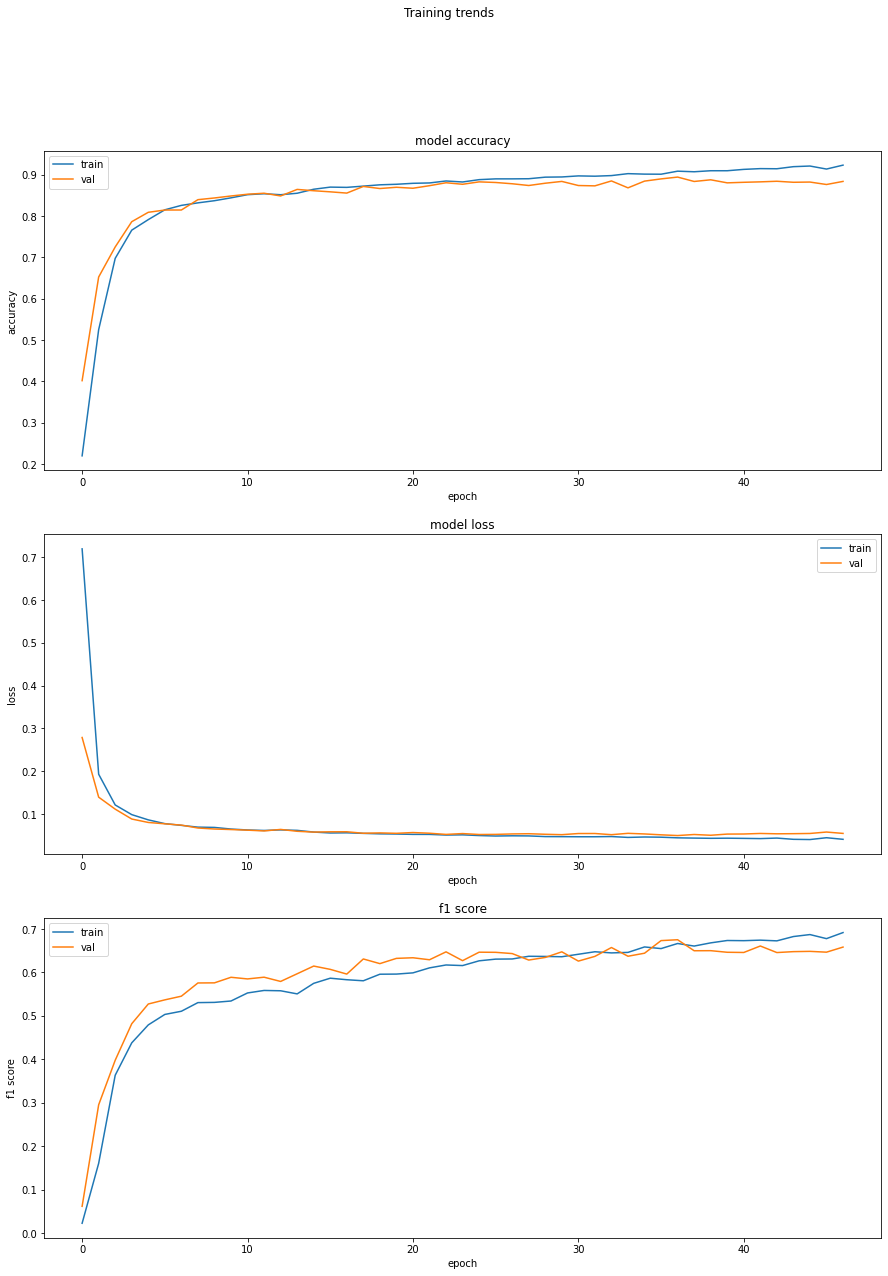

In [116]:
plot_accuracy_loss(best_bilstm_two_dense.history)

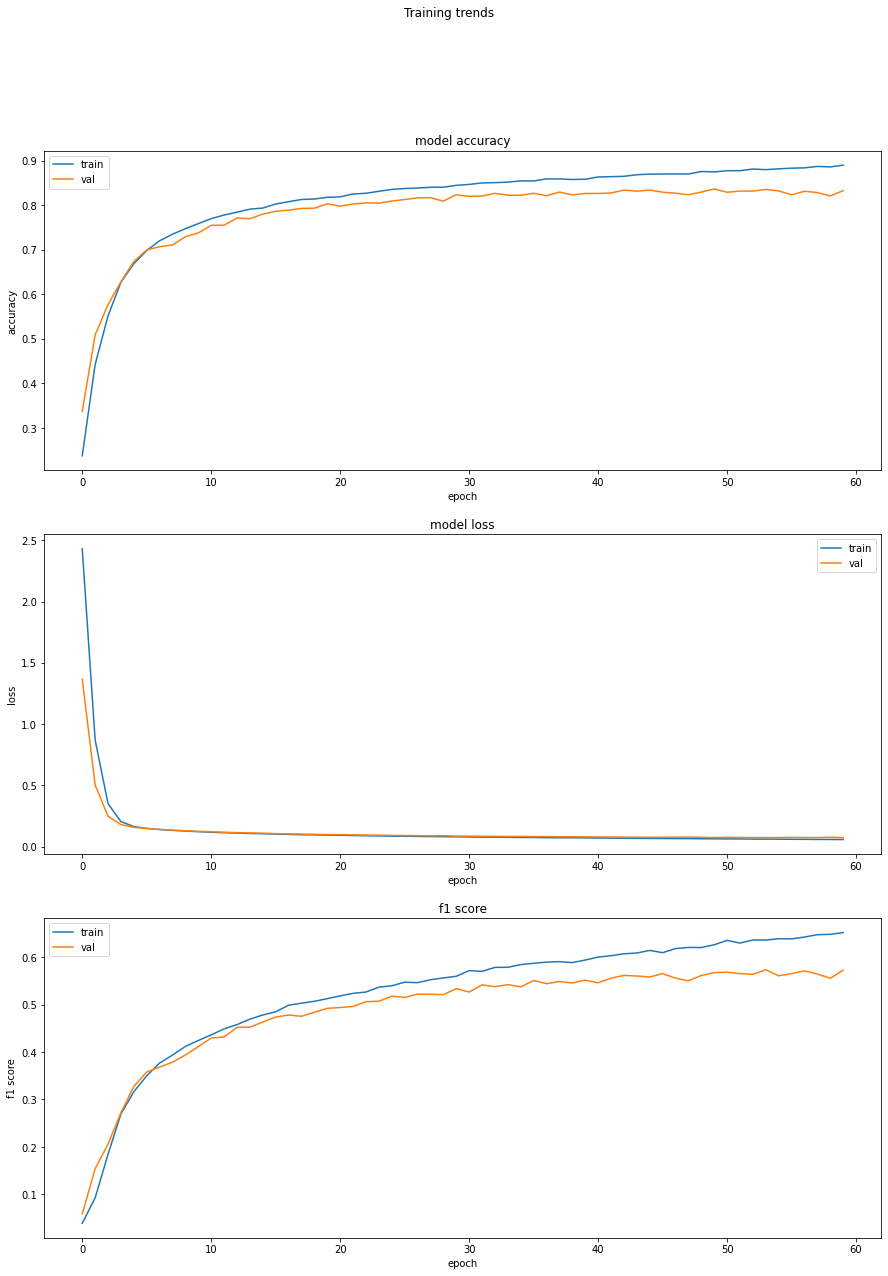

In [117]:
plot_accuracy_loss(best_bigru.history)

We can see the second best model is overfitting whereas the first one is the f1-score between train and val is more near.

## Model Evaluation

Loading the two best performing models

In [141]:
# Select the two best models based on the f1-score on validation set
best_first_model = load_model(os.getcwd() + '/models/bilstm_two_dense.h5',compile=False)

best_second_model = load_model(os.getcwd() + '/models/bigru.h5',compile=False)

# Compile the models
best_first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['val_f1_with_tfa'])
best_second_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['val_f1_with_tfa'])

In [142]:
first_pred_labels = best_first_model.predict(X_test) # bilstm 2 dense
second_pred_labels = best_second_model.predict(X_test) # bigru

21/21 [==============================] - 2s 7ms/step


### Final Error analysis

* Performance on: 
    * the most frequent classes  
    * the less frequent classes 

* precision  

* recall 

* confusion matrix 

* specific misclassified samples.


For the evaluation we need to get rid of tags representing symbols and punctuation, so we have to extract the correct tags that has to be involved in evaluation process. The metric chosen for the evaluation is the macro f1, computed token by token. Indeed, since the output of the network is one-hot encoded we had to collapse the list into an one and only one numpy array, which contains all the tokens without considering sentences.

#### Analyzing some misclassified example sentence from the test set

We now retrieve some sentence from the test set to show some errors.

In [166]:
def predict_and_inverse_labels(idx,model,X_sents,y_tags):
    sample_tags = y_tags[idx]
    sentence = X_sents[idx]
    raw_y_pred = model.predict(np.array([X_test[idx]]))
    whole_pred =  np.concatenate(raw_y_pred)
    above_treshold = whole_pred[np.std(whole_pred, axis=1) > 0.05]
    pred_tags = sort_tags[np.argmax(above_treshold,axis=1)] 
    y_true = ohe.inverse_transform(sample_tags[sample_tags.any(1)]).T

    return sentence,pred_tags, np.concatenate(y_true)

In [167]:
sample_sentence, y_pred, y_gold = predict_and_inverse_labels(12,best_first_model,X_test_sents,y_test)

1/1 [==============================] - 0s 26ms/step


In [180]:
sample_sentence1, y_pred1, y_gold1 = predict_and_inverse_labels(28,best_first_model,X_test_sents,y_test)

1/1 [==============================] - 0s 36ms/step


In [168]:
print(sample_sentence)
print()
print(y_gold)
print()
print(y_pred)

['in' 'composite' 'trading' 'on' 'the' 'new' 'york' 'stock' 'exchange' ','
 'telerate' 'shares' 'closed' 'at' '$' '19.50' ',' 'up' '12.5' 'cents' '.']

['IN' 'JJ' 'NN' 'IN' 'DT' 'NNP' 'NNP' 'NNP' 'NNP' ',' 'NNP' 'NNS' 'VBD'
 'IN' '$' 'CD' ',' 'RB' 'CD' 'NNS' '.']

['IN' 'NNP' 'NN' 'IN' 'DT' 'NNP' 'NNP' 'NNP' 'NNP' ',' 'NNP' 'NNS' 'VBG'
 'IN' '$' 'CD' ',' 'RB' 'CD' 'NNS' '.']


In [181]:
print(sample_sentence1)
print()
print(y_gold1)
print()
print(y_pred1)

['for' 'the' 'year' ',' 'bolstered' 'by' 'the' 'introduction' 'of' 'the'
 'colorliner' 'newspaper-printing' 'press' ',' 'graphics' 'earnings'
 'almost' 'doubled' '.']

['IN' 'DT' 'NN' ',' 'VBN' 'IN' 'DT' 'NN' 'IN' 'DT' 'NNP' 'NN' 'NN' ','
 'NNS' 'NNS' 'RB' 'VBD' '.']

['IN' 'DT' 'NN' ',' 'VBP' 'IN' 'DT' 'NN' 'IN' 'DT' 'NNP' 'NNP' 'NNP' ','
 'JJ' 'NNS' 'RBR' 'VBP' '.']


In [178]:
def get_misclassified(sentence,pred, truth, tags):
    """
    Given a list of predicted tokens and their associated ground truths,
    print the type of misclassifications of the model that produced the,
    where tags names are extracted from the given vocabulary
    """
    observed = pred[pred != truth]
    actual = truth[pred != truth]
    wrong_words = sentence[pred != truth]
    for obs,act,word in zip(observed, actual,wrong_words):
        print(f"The tag {act} was marked as {obs} ==> word misclassified: {word}")

In [179]:
get_misclassified(sample_sentence,y_pred,y_gold,sort_tags)

The tag JJ was marked as NNP ==> word misclassified: composite
The tag VBD was marked as VBG ==> word misclassified: closed


In [182]:
get_misclassified(sample_sentence1,y_pred1,y_gold1,sort_tags)

The tag VBN was marked as VBP ==> word misclassified: bolstered
The tag NN was marked as NNP ==> word misclassified: newspaper-printing
The tag NN was marked as NNP ==> word misclassified: press
The tag NNS was marked as JJ ==> word misclassified: graphics
The tag RB was marked as RBR ==> word misclassified: almost
The tag VBD was marked as VBP ==> word misclassified: doubled


Commento errori

## Confusion matrix

In [123]:
def inverse_transform(targets):
        return np.array(
            [
                ohe.inverse_transform(document[document.any(1)])
                for document in targets
            ]
            , dtype=object
        )

In [124]:
def inverse_transform_probabilities(targets):
        n_classes = targets.shape[2]
        targets = np.array(
            [document[np.std(document, axis=1) > 0.05] for document in targets], dtype=object
        )
        y_pred = np.zeros((len(targets), max([len(document) for document in targets]), n_classes))
        for i, document in enumerate(targets):
            for j, word in enumerate(document):
                y_pred[i, j, np.argmax(word)] = 1

        return inverse_transform(y_pred)


In [183]:
def comparison(model, X_test, y_test):

    raw_y_pred = model.predict(X_test)

    # converting indexes to labels
    y_true_label = inverse_transform(y_test)
    y_pred_label = inverse_transform_probabilities(raw_y_pred)

    y_true_flat = []
    y_pred_flat = []
    for document_predicted, document_true in zip(y_pred_label, y_true_label):
        for word_predicted, word_true in zip (document_predicted, document_true):
            y_pred_flat.append(word_predicted)
            y_true_flat.append(word_true)
    return y_true_flat, y_pred_flat

In [184]:
y_true , y_pred = comparison(best_first_model,X_test,y_test)

21/21 [==============================] - 0s 8ms/step


In [186]:
def get_flattened_comparison(model, X_test, y_test):

    raw_y_pred = model.predict(X_test)

    # converting indexes to labels
    y_true_label = inverse_transform(y_test)
    y_pred_label = inverse_transform_probabilities(raw_y_pred)

    y_true_flat = []
    y_pred_flat = []
    for document_predicted, document_true in zip(y_pred_label, y_true_label):
        for word_predicted, word_true in zip (document_predicted, document_true):
            y_pred_flat.append(word_predicted)
            y_true_flat.append(word_true)
    return y_true_flat, y_pred_flat

In [189]:
punct_symbol_tags=sort_tags[indices]
excluded_symbols = np.array(sorted(set(sort_tags) - set(punct_symbol_tags)))


In [187]:
def evaluate_model(model, X_test, y_test, labels):
    """
    given a trained model and a test set returns the f-score and the confusion matrix
    taking into account only classes in labels
    """
    # show confusion matrix
    y_true_flat, y_pred_flat = comparison(model, X_test, y_test)
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(20,18))
    disp.plot(ax=ax)
    # f1 score
    print("F1 score:\n-------------------------------")
    print(f1_score(y_true_flat, y_pred_flat, labels=labels, average='macro', zero_division=0))

### Confusion matrix

21/21 [==============================] - 0s 8ms/step
F1 score:
-------------------------------
0.7242766120595532


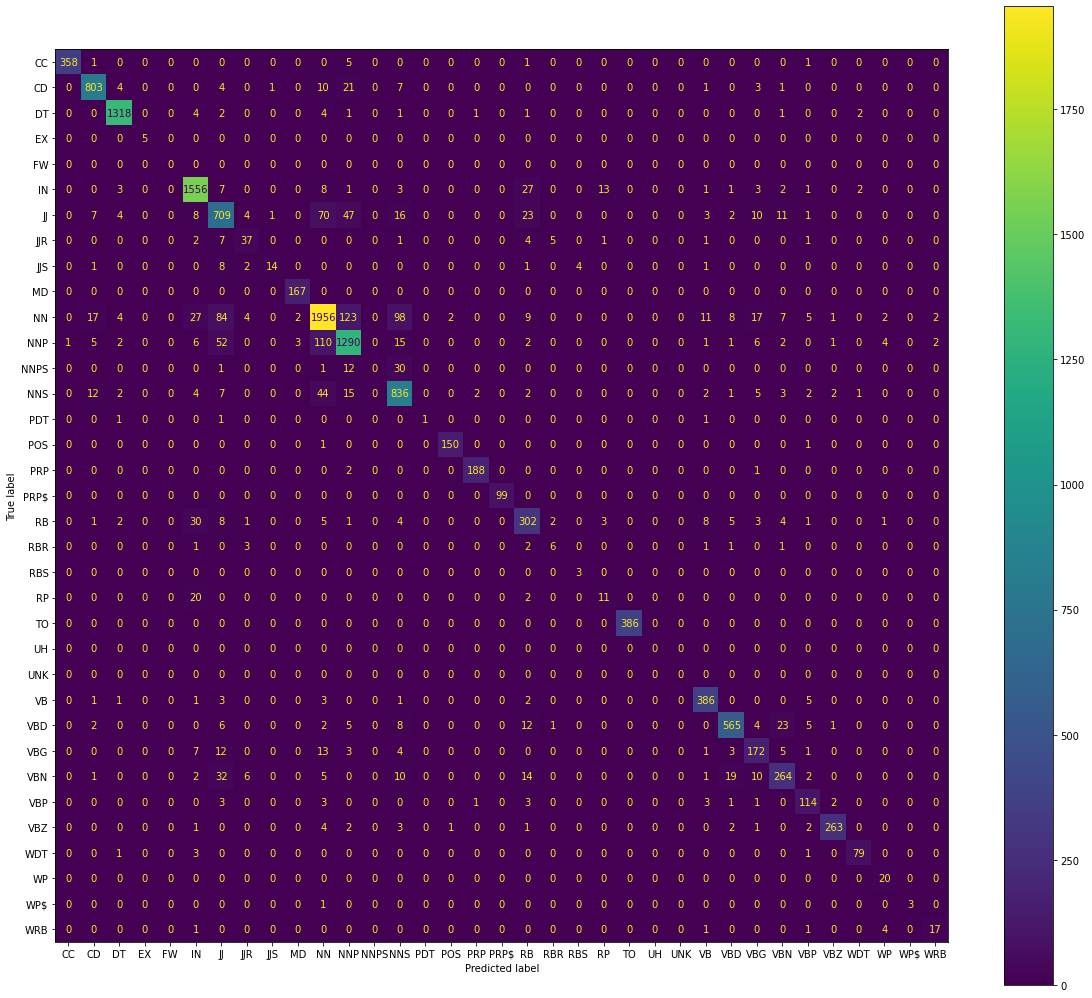

In [190]:
evaluate_model(best_first_model,X_test,y_test,excluded_symbols)

In [191]:
def show_classification_report(model, X_test, y_test, sorted_by=None, ascending=True):
  """
  Show classification report using only classes in names
  """
  y_true, y_pred = get_flattened_comparison(model, X_test, y_test)
  report =  classification_report(y_true, y_pred, output_dict=True, zero_division=0)
  
  # global performance
  keys = ['weighted avg', 'accuracy', 'macro avg']
  global_dict = {key: report[key] for key in keys}
  for key in keys:
    del report[key]

  df = pd.DataFrame.from_dict(report).transpose().round(2)
  if sorted_by:
    df.sort_values(by=sorted_by, ascending=ascending, inplace=True)
  print(df)

  print("\n\n")

  df_glob = pd.DataFrame.from_dict(global_dict).transpose().round(2)
  print(df_glob)

In [192]:
from sklearn.metrics import classification_report

In [193]:
show_classification_report(best_first_model, X_test, y_test, sorted_by=['f1-score'], ascending=False)


21/21 [==============================] - 0s 8ms/step
       precision  recall  f1-score  support
$           1.00    1.00      1.00    209.0
,           1.00    1.00      1.00    787.0
TO          1.00    1.00      1.00    386.0
PRP$        1.00    1.00      1.00     99.0
:           1.00    1.00      1.00     56.0
EX          1.00    1.00      1.00      5.0
MD          0.97    1.00      0.99    167.0
.           0.99    1.00      0.99    633.0
PRP         0.98    0.98      0.98    192.0
POS         0.98    0.99      0.98    152.0
''          0.97    0.99      0.98     70.0
``          0.96    1.00      0.98     73.0
DT          0.98    0.99      0.98   1335.0
CC          0.99    0.98      0.98    366.0
VBZ         0.97    0.94      0.96    280.0
-LRB-       0.90    1.00      0.95     18.0
WDT         0.94    0.94      0.94     84.0
IN          0.93    0.95      0.94   1630.0
CD          0.94    0.94      0.94    858.0
VB          0.91    0.96      0.93    403.0
VBD         0.93    0.8

Result examples of BiLSTM model

* verify and discuss if the results on the test sets are coherent with those on the validation set

* analyze the errors done by your model 


* try to understand which may be the causes and think about how to improve it.